In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [6]:
# Load datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [9]:
# Preprocess: Convert dates to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])


In [12]:
# Merge datasets to create a full dataset
merged_df = transactions_df.merge(customers_df, on='CustomerID')


In [14]:
# Feature Engineering: Aggregate transaction data per customer
customer_features = merged_df.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    avg_spending=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'count'),
    avg_quantity=('Quantity', 'mean')
).reset_index()

In [16]:
# Add profile information (Region) to customer features
customer_features = customer_features.merge(customers_df[['CustomerID', 'Region']], on='CustomerID')


In [18]:
# One-hot encode the 'Region' column
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)


In [20]:
# Scaling numerical features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))


In [22]:
# Use PCA for dimensionality reduction (for visualization)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)


In [24]:
# Determine the optimal number of clusters (elbow method)
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

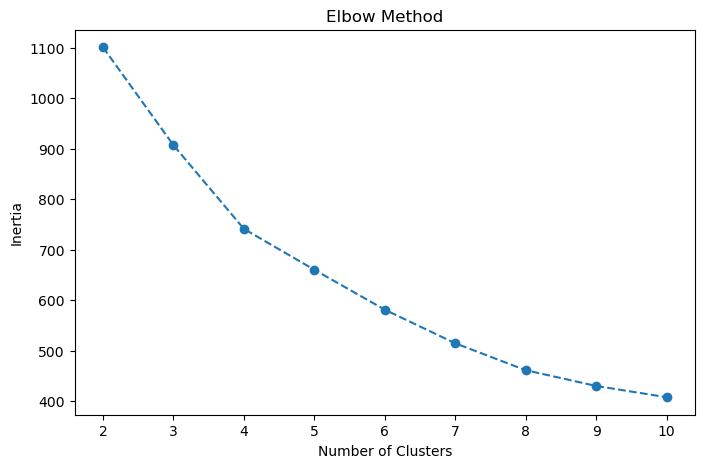

In [26]:
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [28]:
# Choose optimal clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)


In [30]:
# Add cluster labels to customer features
customer_features['Cluster'] = clusters


In [32]:
# Calculate clustering metrics
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)


In [34]:
# Print metrics
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


Davies-Bouldin Index: 1.3318248909489239
Silhouette Score: 0.28110433425396325


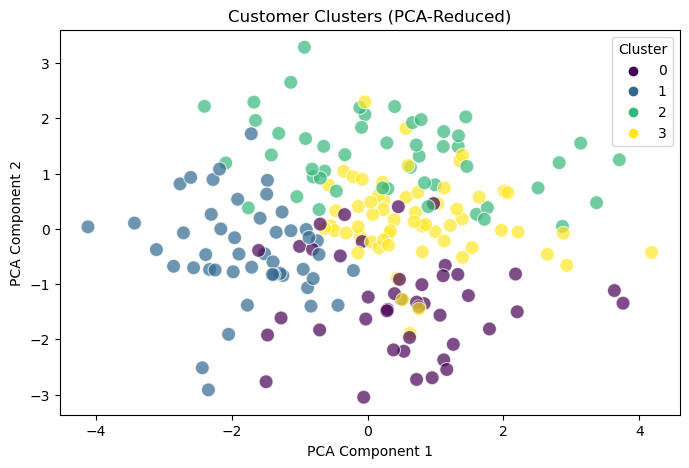

In [36]:
# Visualize clusters in 2D (PCA-reduced space)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=clusters,
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('Customer Clusters (PCA-Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [38]:
# Save the clustered data
customer_features.to_csv('Customer_Clusters.csv', index=False)

print("Customer_Clusters.csv created successfully!")

Customer_Clusters.csv created successfully!
